In [ ]:
import numpy as np
import re
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import LabelEncoder

In [ ]:
# Read Data
df = pd.read_csv('/content/training.1600000.processed.noemoticon.csv', header=None, encoding='latin')
df.columns = ['label', 'id', 'date', 'query', 'user', 'tweet']

# Data reduction
df = df.drop(['id', 'date', 'query', 'user'], axis=1)

In [ ]:
labels_dict = {0:'Negative', 2:'Neutral', 4:'Positive'}

def convert_labels(label):
    return labels_dict[label]

df.label = df.label.apply(lambda x: convert_labels(x))
df

,label,tweet
0,Negative,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,Negative,is upset that he can't update his Facebook by ...
2,Negative,@Kenichan I dived many times for the ball. Man...
3,Negative,my whole body feels itchy and like its on fire
4,Negative,"@nationwideclass no, it's not behaving at all...."
...,...,...
1599995,Positive,Just woke up. Having no school is the best fee...
1599996,Positive,TheWDB.com - Very cool to hear old Walt interv...
1599997,Positive,Are you ready for your MoJo Makeover? Ask me f...
1599998,Positive,Happy 38th Birthday to my boo of alll time!!! ...


In [ ]:
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer

stop_words = stopwords.words('english')
stemmer = SnowballStemmer('english')

punctuations_and_dummies = "@\S+|https?:\S+|http?:\S|[^A-Za-z0-9]+"

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
def preprocess(tweet, will_be_stemmed=False):
        tweet = re.sub(punctuations_and_dummies, ' ', str(tweet).lower()).strip()
        tokens = []
        for token in tweet.split():
            if token not in stop_words:
                if will_be_stemmed:
                    tokens.append(stemmer.stem(token))
                else:
                    tokens.append(token)
        return " ".join(tokens)

df.tweet = df.tweet.apply(lambda tw: preprocess(tw))

In [ ]:
# Remove 0 length tweets
df = df[df.iloc[:,1].astype(str).str.len()!=0]

In [ ]:
from sklearn.model_selection import train_test_split

train_data, test_data = train_test_split(df, test_size=0.2, random_state=7)
print('Training Data', len(train_data), 'Test Data', len(test_data))

train_data.head(10)

Training Data 1273862 Test Data 318466


,label,tweet
927561,Positive,thank
810082,Positive,shakin money tree headed back car business
1153331,Positive,tasmania okay chat ya later
988182,Positive,yeah 100 tab storm towelled raiders awesome
543405,Negative,happy mari asleep gotta start laundry b4 wakes...
22855,Negative,wanting go city raining gotta homework 2
483675,Negative,sitting home bored x
667231,Negative,miss amy cards
1370823,Positive,dinner hubby two us 10 coupo
94439,Negative,know prob running around


In [ ]:
from sklearn.feature_extraction.text import CountVectorizer

#K = 20000
#shuffled_df = df.sample(frac=1).reset_index(drop=True)
first_K_tweets = train_data['tweet']

vectorizer = CountVectorizer(stop_words='english')
vec = vectorizer.fit(first_K_tweets)

vec = vectorizer.transform(first_K_tweets)

# Dictionary
vectorizer.get_feature_names_out()

array(['00', '000', '0000', ..., 'zzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzz',
       'zzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzz',
       'zzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzz'],
      dtype=object)

In [ ]:
test_vec = vectorizer.transform(test_data['tweet'])

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import classification_report

from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import BernoulliNB

classifier_mnb = MultinomialNB()
classifier_mnb.fit(vec, train_data['label'])

MultinomialNB()

In [ ]:
y_prediction = classifier_mnb.predict(test_vec)
score = (classifier_mnb.score(test_vec, test_data['label'])) * 100
print('CountVectorizer Naive Bayes score= '+ str(score) + '%')

CountVectorizer Naive Bayes score= 76.49262401637851%


[[123460  36033]
 [ 38830 120143]]


<Axes: >

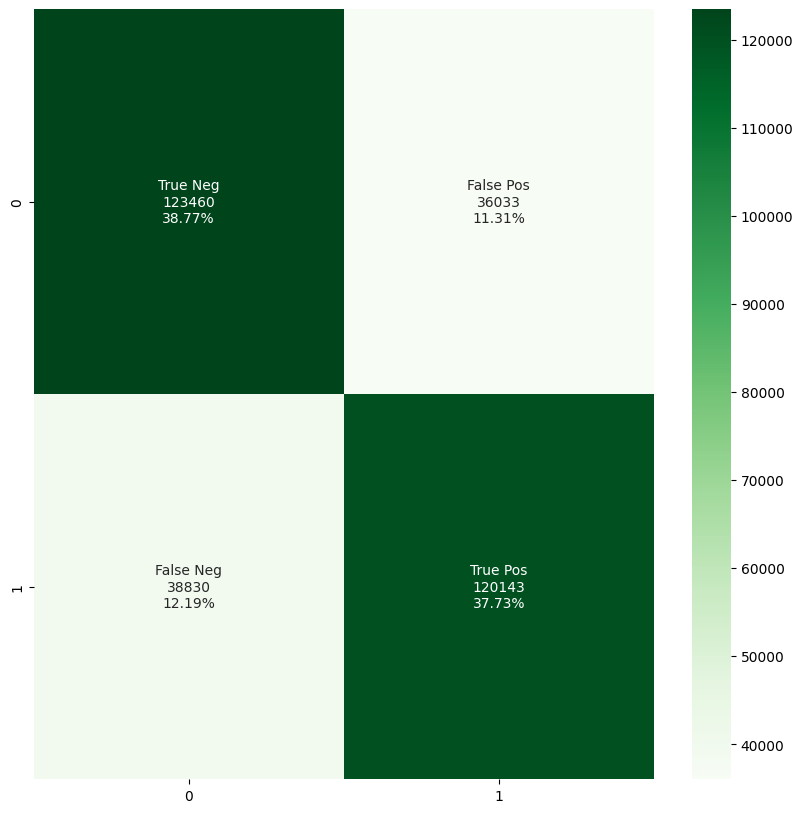

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
import seaborn as sns

cf_matrix = confusion_matrix(test_data['label'], y_prediction)
print(cf_matrix)

plt.figure(figsize = (10,10))
labels = ['True Neg','False Pos','False Neg','True Pos']
labels = np.asarray(labels).reshape(2,2)
group_names = ['True Neg','False Pos','False Neg','True Pos']
group_counts = ["{0:0.0f}".format(value) for value in cf_matrix.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in cf_matrix.flatten()/np.sum(cf_matrix)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='Greens')

In [ ]:
print(classification_report(test_data['label'], y_prediction))

              precision    recall  f1-score   support

    Negative       0.76      0.77      0.77    159493
    Positive       0.77      0.76      0.76    158973

    accuracy                           0.76    318466
   macro avg       0.77      0.76      0.76    318466
weighted avg       0.77      0.76      0.76    318466



In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf_vectorizer = TfidfVectorizer(stop_words='english')

# Learn vocabulary from tweets
tfidf_vec = tfidf_vectorizer.fit(first_K_tweets)

# Vocabulary
vectorizer.vocabulary_

{'thank': 252286,
 'shakin': 226150,
 'money': 169957,
 'tree': 260411,
 'headed': 112750,
 'car': 46434,
 'business': 43465,
 'tasmania': 249206,
 'okay': 185688,
 'chat': 50202,
 'ya': 285085,
 'later': 146465,
 'yeah': 286023,
 '100': 412,
 'tab': 247650,
 'storm': 241783,
 'towelled': 259325,
 'raiders': 207386,
 'awesome': 24849,
 'happy': 111171,
 'mari': 159468,
 'asleep': 22519,
 'gotta': 105609,
 'start': 240043,
 'laundry': 146708,
 'b4': 25729,
 'wakes': 274676,
 'bar': 27977,
 'pilates': 196695,
 '2morrow': 3599,
 'slackin': 232170,
 '4real': 5672,
 'wanting': 275135,
 'city': 54020,
 'raining': 207518,
 'homework': 117230,
 'sitting': 231217,
 'home': 117054,
 'bored': 38216,
 'miss': 167586,
 'amy': 17121,
 'cards': 46586,
 'dinner': 71860,
 'hubby': 119258,
 '10': 411,
 'coupo': 60487,
 'know': 142438,
 'prob': 202716,
 'running': 217885,
 'great': 106617,
 'example': 86289,
 'choice': 52370,
 'watch': 275592,
 'good': 104720,
 'news': 178861,
 'week': 276834,
 'said': 2

In [ ]:
tfidf_vec = tfidf_vectorizer.transform(first_K_tweets)

In [ ]:
tfidf_test_vec = tfidf_vectorizer.transform(test_data['tweet'])

In [ ]:
tfidf_classifier = MultinomialNB()
tfidf_classifier.fit(tfidf_vec, train_data['label'])

MultinomialNB()

In [ ]:
y_prediction = tfidf_classifier.predict(tfidf_test_vec)
score = (tfidf_classifier.score(tfidf_test_vec, test_data['label'])) * 100
print("tf-idf Näive_Bayes score = " + str(score) + "%")

tf-idf Näive_Bayes score = 75.89475799614401%


[[122167  37326]
 [ 39441 119532]]


<Axes: >

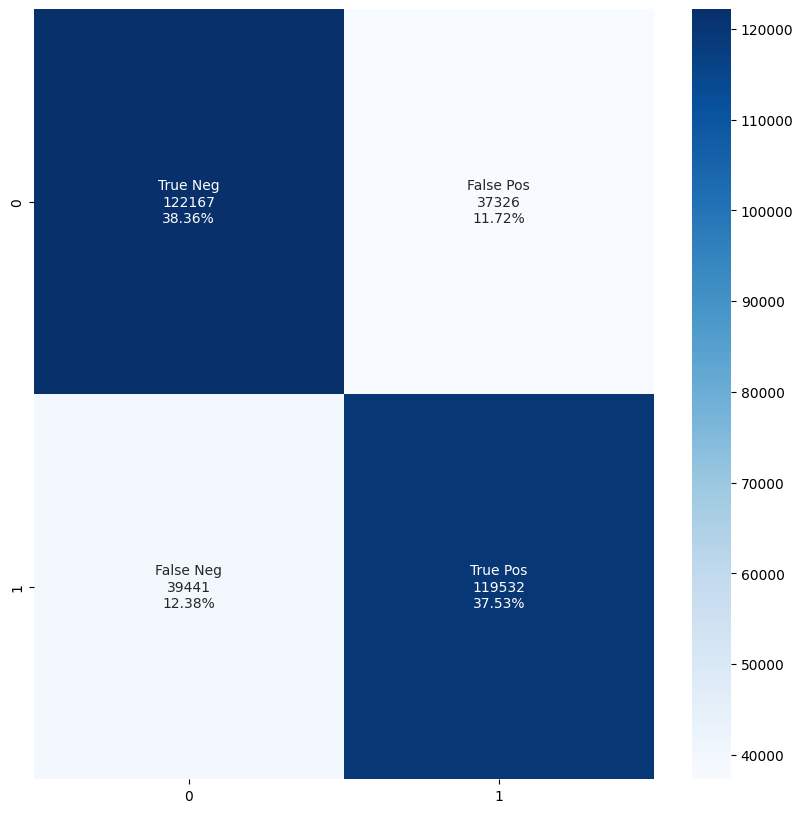

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
import seaborn as sns

cf_matrix = confusion_matrix(test_data['label'], y_prediction)
print(cf_matrix)

plt.figure(figsize = (10,10))
labels = ['True Neg','False Pos','False Neg','True Pos']
labels = np.asarray(labels).reshape(2,2)
group_names = ['True Neg','False Pos','False Neg','True Pos']
group_counts = ["{0:0.0f}".format(value) for value in cf_matrix.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in cf_matrix.flatten()/np.sum(cf_matrix)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='Blues')

In [ ]:
print(classification_report(test_data['label'], y_prediction))

              precision    recall  f1-score   support

    Negative       0.76      0.77      0.76    159493
    Positive       0.76      0.75      0.76    158973

    accuracy                           0.76    318466
   macro avg       0.76      0.76      0.76    318466
weighted avg       0.76      0.76      0.76    318466



In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import classification_report
from sklearn.svm import LinearSVC

# Assuming train_data['tweet'] is a list of strings
first_K_tweets = train_data['tweet']

# TF-IDF vectorization
vectorizer = TfidfVectorizer(stop_words='english')
vec = vectorizer.fit_transform(first_K_tweets)

# Linear SVM classifier
classifier_svm = LinearSVC()
classifier_svm.fit(vec, train_data['label'])



LinearSVC()

In [ ]:
y_prediction = classifier_svm.predict(test_vec)
score = (classifier_svm.score(test_vec, test_data['label'])) * 100
print('Linear SVM score= '+ str(score) + '%')

Linear SVM score= 77.17118938913417%


[[126397  33096]
 [ 39606 119367]]


<Axes: >

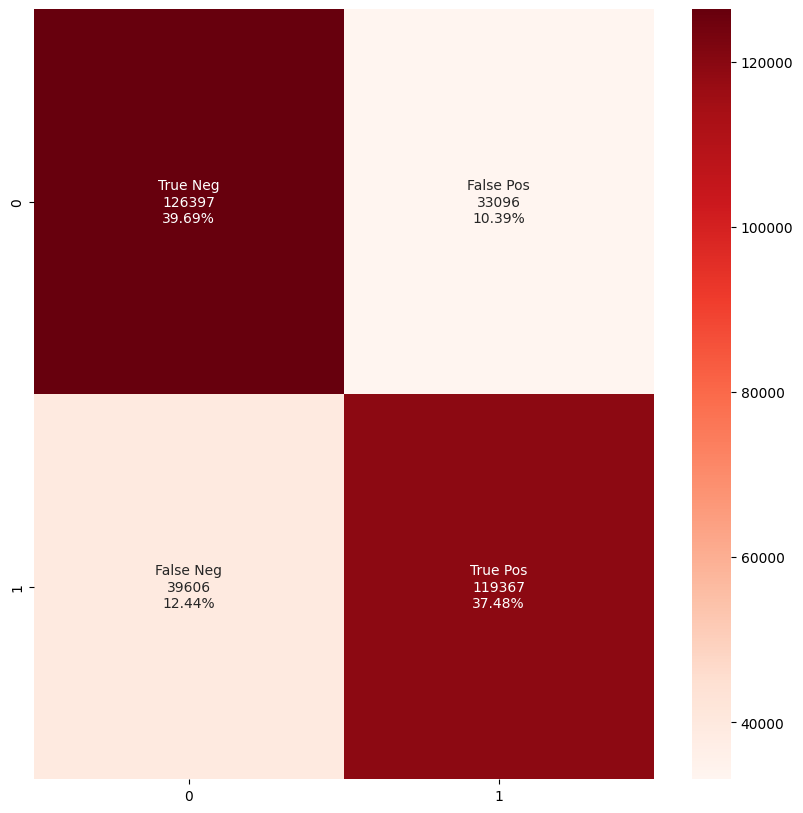

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
import seaborn as sns

cf_matrix = confusion_matrix(test_data['label'], y_prediction)
print(cf_matrix)

plt.figure(figsize = (10,10))
labels = ['True Neg','False Pos','False Neg','True Pos']
labels = np.asarray(labels).reshape(2,2)
group_names = ['True Neg','False Pos','False Neg','True Pos']
group_counts = ["{0:0.0f}".format(value) for value in cf_matrix.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in cf_matrix.flatten()/np.sum(cf_matrix)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='Reds')

In [ ]:
print(classification_report(test_data['label'], y_prediction))

              precision    recall  f1-score   support

    Negative       0.76      0.79      0.78    159493
    Positive       0.78      0.75      0.77    158973

    accuracy                           0.77    318466
   macro avg       0.77      0.77      0.77    318466
weighted avg       0.77      0.77      0.77    318466



In [ ]:
from collections import defaultdict

In [ ]:
from sklearn import preprocessing
label_encoder = preprocessing.LabelEncoder()
df['label']= label_encoder.fit_transform(df['label'])

df['label'].unique()

<ipython-input-29-f2269adacd00>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['label']= label_encoder.fit_transform(df['label'])


array([0, 1])

In [ ]:
X_train,X_test,y_train,y_test = train_test_split(df["tweet"],df["label"], test_size=0.2, random_state=7)

In [ ]:
vect = CountVectorizer(min_df=5,ngram_range=(1,2)).fit(X_train)
len(vect.get_feature_names_out())

239534

In [ ]:
import pickle
with open('vect.pkl', 'wb') as file:
    pickle.dump(vect, file)

In [ ]:
X_train_vectorized = vect.transform(X_train)
X_test_vectorized = vect.transform(X_test)

In [ ]:
from sklearn.linear_model import LogisticRegression
model_lr = LogisticRegression()
model_lr.fit(X_train_vectorized,y_train)

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

In [ ]:
predictions = model_lr.predict(vect.transform(X_test))

In [ ]:
from sklearn.metrics import accuracy_score

score = accuracy_score(y_test, predictions)*100
print('Logistic Regression using N-gram score = ',score,"%")

Logistic Regression using N-gram score =  78.91643063937751 %


Confusion Matrix:
[[121559  37934]
 [ 29210 129763]]


<Axes: >

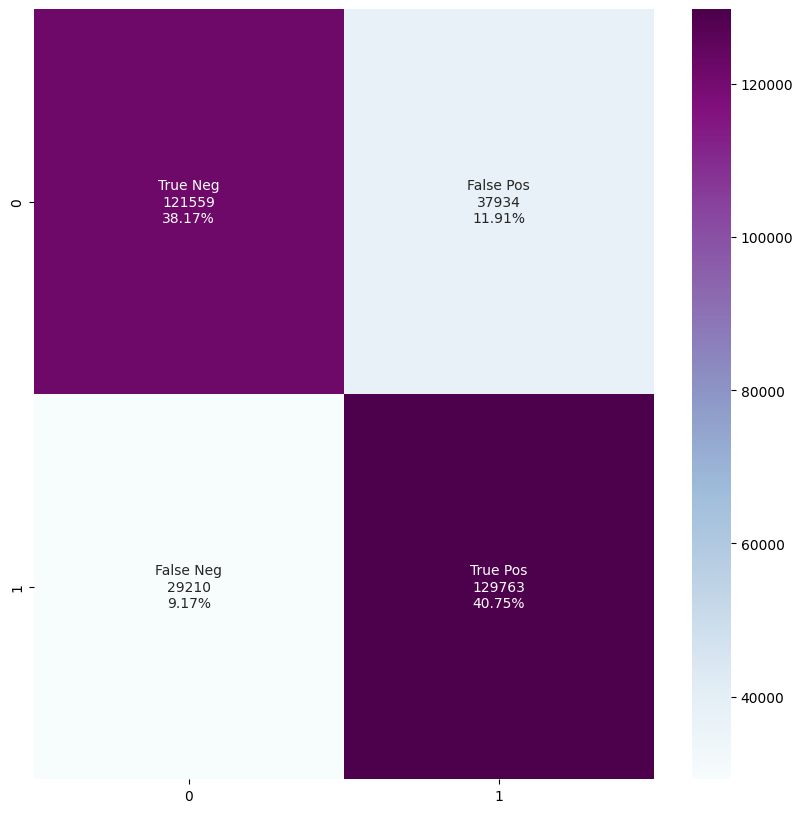

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

y_pred = model_lr.predict(X_test_vectorized)

cf_matrix = confusion_matrix(y_test, y_pred)

print("Confusion Matrix:")
print(cf_matrix)

plt.figure(figsize = (10,10))
labels = ['True Neg','False Pos','False Neg','True Pos']
labels = np.asarray(labels).reshape(2,2)
group_names = ['True Neg','False Pos','False Neg','True Pos']
group_counts = ["{0:0.0f}".format(value) for value in cf_matrix.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in cf_matrix.flatten()/np.sum(cf_matrix)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='BuPu')

In [ ]:
from sklearn.metrics import classification_report
target_names = ['negative', 'positive']
prinreport = classification_report(y_test, y_pred,target_names=target_names)
print("Classification Report:\n", prinreport)


Classification Report:
               precision    recall  f1-score   support

    negative       0.81      0.76      0.78    159493
    positive       0.77      0.82      0.79    158973

    accuracy                           0.79    318466
   macro avg       0.79      0.79      0.79    318466
weighted avg       0.79      0.79      0.79    318466



In [ ]:
from sklearn.ensemble import BaggingClassifier, VotingClassifier
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report

# Assuming you have your features in X and labels in y
# Split your data into training and testing sets
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define your base models
# base_model_nb = GaussianNB()
# base_model_lr = LogisticRegression()
# base_model_svm = SVC()
# X_train,X_test,y_train,y_test = train_test_split(df["tweet"],df["label"], test_size=0.2, random_state=7)
# Create a bagging classifier with the three base models
bagging_model = BaggingClassifier(
    base_estimator=VotingClassifier(estimators=[
        ('naive_bayes_mnb', classifier_mnb),
        ('naive_bayes_tfidf', tfidf_classifier),
        ('logistic_regression_n_gram', model_lr),
        ('svm', classifier_svm)
    ], voting='hard'),
    n_estimators=1,
    random_state=42
)

# Fit the bagging model on the training data
bagging_model.fit(X_train_vectorized, y_train)

# Make predictions on the test set



/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


BaggingClassifier(base_estimator=VotingClassifier(estimators=[('naive_bayes_mnb',
                                                               MultinomialNB()),
                                                              ('naive_bayes_tfidf',
                                                               MultinomialNB()),
                                                              ('logistic_regression_n_gram',
                                                               LogisticRegression()),
                                                              ('svm',
                                                               LinearSVC())]),
                  n_estimators=1, random_state=42)

In [ ]:
y_pred = bagging_model.predict(X_test_vectorized)

# Evaluate the performance of the bagging model
print("Bagging Accuracy:", accuracy_score(y_test, y_pred))
print("Bagging Classification Report:\n", classification_report(y_test, y_pred))

Bagging Accuracy: 0.7772289663574762
Bagging Classification Report:
               precision    recall  f1-score   support

           0       0.76      0.81      0.78    159493
           1       0.80      0.74      0.77    158973

    accuracy                           0.78    318466
   macro avg       0.78      0.78      0.78    318466
weighted avg       0.78      0.78      0.78    318466



In [ ]:
input_data = (["nice job thanks"])
input_data_reshaped = vect.transform(input_data)
prediction = bagging_model.predict(input_data_reshaped)
print(prediction[0])

if (prediction[0] == 0):
  print('Negative')
else:
  print('Positive')

1
Positive


In [ ]:
import pickle
filename = 'MLmodel.sav'
pickle.dump( bagging_model, open(filename, 'wb'))

In [ ]:
# loading the saved model
loaded_model = pickle.load(open('MLmodel.sav', 'rb'))

In [ ]:
import pickle
from sklearn.feature_extraction.text import CountVectorizer

# Create and fit the CountVectorizer
vect = CountVectorizer(min_df=5, ngram_range=(1, 2))
vect.fit(X_train)

# Save the vectorizer to a file using pickle.dump
with open('vectorizer.pkl', 'wb') as file:
    pickle.dump(vect, file)
